<a href="https://colab.research.google.com/github/MaxTechniche/DS20_Unit_1_Build/blob/master/Jacob_Maxfield_Unit_1_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMDb Top 250 List**

###### Imports

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import defaultdict

##### Gather Datasets (Web Scraping)

###### Functions (I've already preprocessed it below.)

In [2]:
def convert_runtime(time):
  """Converts a string movie runningtime "#h ##min" to a int of total minutes."""
  runtime = time.split()
  print(runtime)
  if len(runtime) > 1:
    hours = int(runtime[0][:-1])
    minutes = int(runtime[1][:-3])
  elif len(runtime) == 1:
    if runtime[0][-1:] == 'h':
      hours = int(runtime[0][:-1])
      minutes = 0
    else:
      minutes = int(runtime[0][:-3])
      hours = 0
  else:
    return None
  converted_time = hours * 60 + minutes

  return converted_time

def get_imdb_top_250():
  """Gets list of the top 250 IMDb movies Titles and IDs. Returns a dictionary."""
  t_url = "https://www.imdb.com/chart/top"
  source = requests.get(t_url).text
  soup = BeautifulSoup(source, 'html.parser')

  movie_links = soup.find('tbody', class_='lister-list').find_all('a')
  movie_titles = {title['href'][9:-1]:title.text for title in movie_links}
  return movie_titles

def movie_info(df):
  """Gets list of the top 250 IMDb movies extended info. Returns a dictionary."""
  imdb = "https://www.imdb.com/"
  movie_info = defaultdict(dict)

  for id in df['ID']:
    source = requests.get(imdb + 'title/tt' + id).text
    info = BeautifulSoup(source, 'lxml').find('div', class_='subtext')

    rating = info.next_element.strip()

    runtime = convert_runtime(info.time.text.strip())

    try:
      genres = ', '.join([genre.text.strip() for genre in info.find_all(href=re.compile('/search'))])
    except AttributeError:
      genres = None

    try:
      release_date = info.find(href=re.compile('/title/tt')).text.strip()
      release_country = re.search('\([\w ]+\)', release_date)
      if release_country:
        release_country = release_country.group(0)
        release_date = release_date.strip(release_country).strip()
        release_country = release_country.lstrip('(').rstrip(')')
    except AttributeError:
      release_date = None
      release_country = None
    for name, val in zip(['Rating', 'Runtime', 'Genres', 'Release_Date', 'Release_Country'], [rating, runtime, genres, release_date, release_country]):
      movie_info[id][name] = val
  return movie_info
  
def merge_title_data():
  movie_titles = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_imdb_list.csv'
  extended_movie_info = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_movies_info.csv'

  df_titles = pd.read_csv(movie_titles)
  df_info = pd.read_csv(extended_movie_info)

  df = pd.merge(df_titles, df_info, on='ID')
  df.to_csv('top_250_IMDb_movies.csv', index=False)
  return pd.read_csv('top_250_IMDb_movies.csv')

def get_int(comma_num):
  return int(''.join(comma_num.split(',')))

def get_rankings(df):
  rankings_dict = defaultdict(dict)
  rank_names = [
      *[str(x) for x in range(10, 0, -1)],
      *['Rank_' + gender + star for gender in ['All_', 'Male_', 'Female_'] for star in ['All_Ages','<18','18-29','30-44','45+']],
      *['Count_' + gender + count for gender in ['All_', 'Male_', 'Female_'] for count in ['All_Ages','<18','18-29','30-44','45+']]]
  
  title_link = 'https://www.imdb.com/title/tt'
  ids = df['ID']

  for id in ids:
    search = title_link + id + 'ratings'
    page = BeautifulSoup(requests.get(search).text, 'lxml')

    rank_values = []

    # Total Stars
    rank_values.extend([get_int(r.text.strip()) for r in page.find_all('div', class_='leftAligned')[1:11]])
    rank_values.extend([float(r.text.strip()) for r in page.find_all('div', class_='bigcell')[:15]])
    rank_values.extend([get_int(r.text.strip()) for r in page.findAll('a', href=re.compile('/title/tt' + id + 'ratings\?demo'))[:15]])
    
    for name, val in zip(rank_names, rank_values):
      rankings_dict[id][name] = val
  ranks = pd.DataFrame.from_dict(rankings_dict).T
  ranks.reset_index().rename({'index':'ID'}, axis=1).to_csv('top_250_rankings.csv', index=False)
  return pd.read_csv('top_250_rankings.csv')


###### Do not uncomment!

In [3]:
# imdb = "https://www.imdb.com/"

# titles = imdb_top_titles()
# df = pd.DataFrame.from_dict(data=movie_info(titles, imdb)).T
# df = df.reset_index().rename(columns={'index':'ID'})

# df = merge_title_data()

# Full Movie Titles link
# movies_link = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/top_250_IMDb_movies.csv'
# df = pd.read_csv(movies_link)

# rankings = get_rankings(df)
# df = pd.merge(df, rankings, on='ID')
# df['Release_Date'][51] = 'September 1954'
# df['Release_Date'] = pd.to_datetime(df['Release_Date'])
# df.to_csv('IMDb_Top_250.csv', index=False)

# Start here:

In [29]:
imdb_list = 'https://raw.githubusercontent.com/MaxTechniche/DS20_Unit_1_Build/master/IMDb_Top_250.csv'
df = pd.read_csv(imdb_list)
# Replace and reduce ratings as well as EDA
rating_system = {'Passed':'Other','Approved':'Other','GP':'Other',np.NaN:'Not Rated','':'Not Rated'}
df['Rating'] = df['Rating'].replace(rating_system)
df

,ID,Title_Name,Year,Rating,Runtime,Genres,Release_Date,Release_Country,10,9,8,7,6,5,4,3,2,1,Rank_All_All_Ages,Rank_All_<18,Rank_All_18-29,Rank_All_30-44,Rank_All_45+,Rank_Male_All_Ages,Rank_Male_<18,Rank_Male_18-29,Rank_Male_30-44,Rank_Male_45+,Rank_Female_All_Ages,Rank_Female_<18,Rank_Female_18-29,Rank_Female_30-44,Rank_Female_45+,Count_All_All_Ages,Count_All_<18,Count_All_18-29,Count_All_30-44,Count_All_45+,Count_Male_All_Ages,Count_Male_<18,Count_Male_18-29,Count_Male_30-44,Count_Male_45+,Count_Female_All_Ages,Count_Female_<18,Count_Female_18-29,Count_Female_30-44,Count_Female_45+
0,0111161/,The Shawshank Redemption,1994,R,142,Drama,1994-10-14,USA,1262354.0,583880.0,265474.0,85024.0,25611.0,13192.0,6428.0,4628.0,4312.0,34201.0,9.3,9.3,9.3,9.3,9.1,9.3,9.3,9.3,9.3,9.1,9.2,9.0,9.2,9.2,9.2,2285104.0,1859.0,487165.0,867022.0,205233.0,1394422.0,1308.0,387767.0,724633.0,166576.0,274622.0,259.0,88180.0,129811.0,34510.0
1,0068646/,The Godfather,1972,R,175,"Crime, Drama",1972-03-24,USA,815469.0,390277.0,192975.0,76283.0,29274.0,16195.0,8248.0,6133.0,5799.0,36698.0,9.2,9.2,9.2,9.2,9.1,9.2,9.2,9.3,9.2,9.2,8.9,8.8,8.9,8.9,8.9,1577351.0,1178.0,310646.0,621830.0,160127.0,1006212.0,851.0,259481.0,538999.0,133895.0,152074.0,155.0,44131.0,74072.0,23038.0
2,0071562/,The Godfather: Part II,1974,R,202,"Crime, Drama",1974-12-18,USA,474065.0,315817.0,170707.0,68952.0,25735.0,12383.0,6081.0,4273.0,3841.0,20194.0,9.0,9.1,9.0,9.0,8.9,9.0,9.1,9.1,9.0,9.0,8.7,9.0,8.8,8.7,8.7,1102048.0,700.0,207660.0,437435.0,119462.0,713710.0,518.0,178064.0,383327.0,100765.0,96294.0,101.0,25330.0,47896.0,16400.0
3,0468569/,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",2008-07-18,USA,1010114.0,631933.0,345435.0,134595.0,48559.0,22780.0,11238.0,7970.0,7077.0,30045.0,9.0,9.2,9.2,9.0,8.4,9.1,9.2,9.3,9.0,8.4,8.7,8.8,8.8,8.7,8.2,2249746.0,2039.0,519664.0,883542.0,146568.0,1411141.0,1507.0,420381.0,746893.0,123426.0,251133.0,216.0,87683.0,124540.0,20271.0
4,0050083/,12 Angry Men,1957,Other,96,"Crime, Drama",1957-04-10,USA,238674.0,219032.0,130270.0,47180.0,15489.0,6143.0,2823.0,1680.0,1461.0,8172.0,8.9,9.1,9.1,8.9,8.7,9.0,9.2,9.1,8.9,8.7,8.8,8.5,8.9,8.8,8.7,670924.0,583.0,148257.0,246713.0,67702.0,419208.0,437.0,122266.0,211856.0,56882.0,69330.0,74.0,23215.0,31869.0,9632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0088247/,The Terminator,1984,R,107,"Action, Sci-Fi",1984-10-26,USA,114809.0,158924.0,278749.0,155130.0,47473.0,15702.0,6112.0,3190.0,2148.0,4082.0,8.0,8.1,7.9,8.0,8.2,8.1,8.1,7.9,8.1,8.3,7.7,8.2,7.5,7.7,8.0,786319.0,500.0,129901.0,337992.0,95037.0,525656.0,402.0,113312.0,298154.0,81232.0,66670.0,54.0,14718.0,35655.0,12274.0
246,10431500/,Yedinci Kogustaki Mucize,2019,Not Rated,132,Drama,2019-10-11,Turkey,10158.0,6668.0,6532.0,3346.0,1300.0,538.0,246.0,144.0,100.0,317.0,8.3,8.6,8.3,8.2,8.0,8.2,8.3,8.2,8.1,8.0,8.5,9.0,8.5,8.4,8.3,29349.0,92.0,7580.0,8455.0,1257.0,14920.0,58.0,5088.0,6703.0,1034.0,4062.0,16.0,1936.0,1423.0,182.0
247,0111495/,Three Colors: Red,1994,R,99,"Drama, Mystery, Romance",1994-11-23,USA,17426.0,19183.0,26553.0,14016.0,4868.0,2111.0,942.0,583.0,507.0,1931.0,8.1,8.2,8.3,8.0,7.9,8.0,8.6,8.3,8.0,7.9,8.0,7.4,8.2,8.0,8.0,88120.0,46.0,14151.0,36183.0,15192.0,54716.0,28.0,10863.0,29291.0,12609.0,12479.0,15.0,3090.0,6482.0,2373.0
248,5323662/,A Silent Voice: The Movie,2016,Not Rated,130,"Animation, Drama, Family",2016-09-17,Japan,10726.0,9927.0,10619.0,6048.0,2360.0,862.0,372.0,188.0,131.0,302.0,8.1,8.4,8.3,7.8,7.6,8.1,8.4,8.3,7.9,7.6,8.0,8.2,8.0,7.8,7.6,41535.0,205.0,12950.0,8105.0,1163.0,20212.0,132.0,9656.0,6574.0,959.0,5166.0,41.0,2848.0,1375.0,172.0


In [60]:
mini_df = df[['Title_Name', 'Rating', 'Runtime', 'Rank_All_All_Ages', 'Rank_Male_All_Ages', 'Rank_Female_All_Ages','Count_All_All_Ages']]
mini_df.shape

(250, 7)

In [61]:
len(genres)

21

In [31]:
# Removing hyphens so I can eval them.
df['Genres'] = df['Genres'].str.replace('Sci-Fi','SciFi')
df['Genres'] = df['Genres'].str.replace('Film-Noir','FilmNoir')


In [32]:
# Convert Release_Date to datetime object
df['Release_Date'] = pd.to_datetime(df['Release_Date'])
df['Release_Date'].value_counts().head()

1982-06-25    2
1995-11-22    2
2019-11-15    2
1994-10-14    2
2003-03-28    2
Name: Release_Date, dtype: int64

**SAME DAY RELEASES?!**

In [33]:
# Creating dataframe of release date pairs
rd_pairs = df[df['Release_Date'].isin(df['Release_Date'].value_counts().head(5).index)]
rd_pairs = rd_pairs.sort_values(['Release_Date', 'Rank_All_All_Ages'])

#### Explanitory Graph of Release Date Pairs

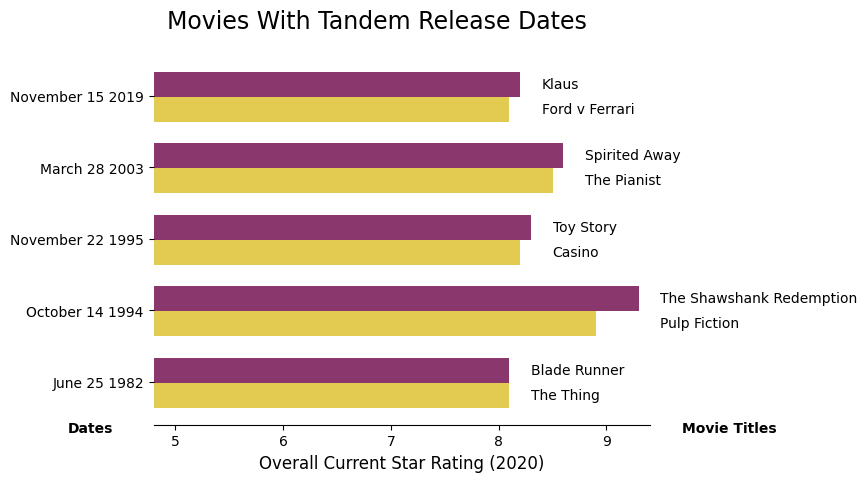

In [99]:
barHeight = 0.35

ranks1 = rd_pairs['Rank_All_All_Ages'][::2]
ranks2 = rd_pairs['Rank_All_All_Ages'][1::2]

names1 = rd_pairs['Title_Name'][::2]
names2 = rd_pairs['Title_Name'][1::2]

bar1 = np.arange(len(ranks1)) -.19
bar2 = [y + barHeight for y in bar1]

plt.style.use('default')

plt.barh(bar1, ranks1, barHeight, color='#E3CB51')
plt.barh(bar2, ranks2, barHeight, color='#89376D')

plt.yticks(bar1+.19, [' '.join([d.month_name(), str(d.day), str(d.year)]) for d in pd.Series(rd_pairs['Release_Date'].unique())])
plt.xticks(range(5, 11))

plt.xlabel('Overall Current Star Rating (2020)',size=12)

plt.title('Movies With Tandem Release Dates', x=.45, y=1.05, size=17)

for x, y, name in zip([*ranks2, *ranks2], [*bar1, *bar2], [*rd_pairs['Title_Name'][::2], *rd_pairs['Title_Name'][1::2]]):
  plt.text(x+.2, y-.05, name)

for spine in ['right', 'top', 'left']:
  plt.gca().spines[spine].set_visible(False)

plt.text(4, -.7, 'Dates',weight='bold')
plt.text(9.7, -.7, 'Movie Titles', weight='bold')

plt.xlim(4.8, 9.4)

plt.show()

#### Other EDA

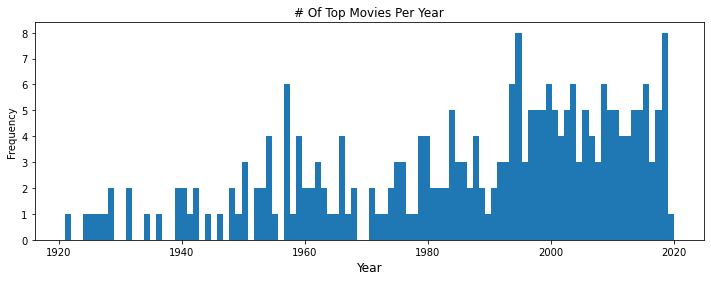

In [74]:
# EDA of Number of Releases in each year
plt.figure(figsize=(12, 4))
df['Year'].plot.hist(bins=100)
plt.title('# Of Top Movies Per Year')
plt.xlabel('Year', size=12)
plt.show()

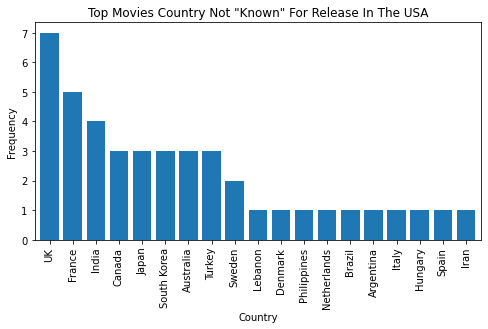

In [79]:
# EDA of Releases not in USA
plt.figure(figsize=(8, 4))
df['Release_Country'].value_counts()[1:].plot.bar(width=.8)
plt.title('Top Movies Country Not "Known" For Release In The USA')
plt.ylabel('Frequency')
plt.xlabel('Country')
plt.show()

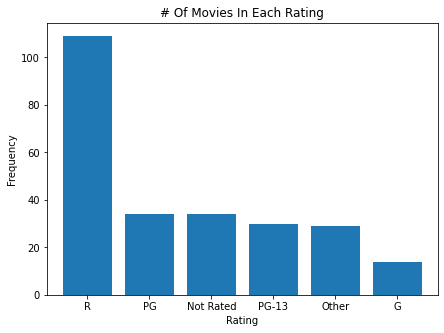

In [94]:
plt.figure(figsize=(7, 5))
df['Rating'].value_counts().plot.bar(width=.8, rot=0)
plt.title('# of movies in each rating'.title())
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.show()

In [39]:
# Get set of genres
genres = set([genre for x in df['Genres'] for genre in x.split(', ')])

In [40]:
# Create evals for 
genre_dfs = []
for genre in genres:
  globals()[genre] = df[df['Genres'].str.contains(genre)]
  genre_dfs.append(eval(genre))

In [41]:
genre_rank_dict = {}

for genre_name, genre_df in zip(genres, genre_dfs):
  genre_rank_dict[genre_name] = genre_df[[column for column in genre_df.columns if 'Rank' in column]]

genre_count_dict = {}

for genre_name, genre_df in zip(genres, genre_dfs):
  genre_count_dict[genre_name] = genre_df[[column for column in genre_df.columns if 'Count' in column]]

In [42]:
genre_list = []
for genre_mult in [[genre] * 4 for genre in genres]:
  genre_list.extend(genre_mult)

In [43]:
describe_rank_df = pd.DataFrame(columns=['index'] + [column for column in genre_rank_dict['Action'].columns if 'Rank_' in column])
for genre in genres:
  g_df = genre_rank_dict[genre].describe().T[['mean','std','min','max']].T.reset_index().rename({'index':'type'})
  g_df.index = [genre]*4
  describe_rank_df = describe_rank_df.append(g_df)

In [44]:
rank_mean_df = describe_rank_df[describe_rank_df['index'] == 'mean'].sort_values('Rank_All_All_Ages')

In [45]:
describe_rank_df

,index,Rank_All_All_Ages,Rank_All_<18,Rank_All_18-29,Rank_All_30-44,Rank_All_45+,Rank_Male_All_Ages,Rank_Male_<18,Rank_Male_18-29,Rank_Male_30-44,Rank_Male_45+,Rank_Female_All_Ages,Rank_Female_<18,Rank_Female_18-29,Rank_Female_30-44,Rank_Female_45+
Drama,mean,8.310497,8.333702,8.417127,8.261878,8.079558,8.304972,8.379558,8.424309,8.266298,8.074033,8.234254,8.000000,8.296685,8.192265,8.080110
Drama,std,0.236996,0.429886,0.248069,0.258059,0.423047,0.248836,0.407801,0.259840,0.266713,0.423399,0.305393,0.772442,0.312499,0.314194,0.504030
Drama,min,8.000000,6.800000,8.000000,7.800000,5.800000,7.900000,7.000000,8.000000,7.800000,5.900000,6.800000,3.200000,7.300000,6.900000,5.000000
Drama,max,9.300000,9.300000,9.300000,9.300000,9.100000,9.300000,9.300000,9.300000,9.300000,9.200000,9.200000,10.000000,9.200000,9.200000,9.200000
Thriller,mean,8.250000,8.234211,8.323684,8.223684,8.092105,8.260526,8.302632,8.344737,8.228947,8.100000,8.144737,7.910526,8.163158,8.107895,8.039474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Biography,max,8.900000,9.000000,9.000000,8.900000,8.700000,8.900000,9.100000,9.000000,8.900000,8.700000,9.200000,9.500000,9.200000,9.200000,9.000000
FilmNoir,mean,8.266667,8.300000,8.266667,8.233333,8.400000,8.266667,8.333333,8.266667,8.233333,8.400000,8.166667,8.033333,8.066667,8.133333,8.366667
FilmNoir,std,0.152753,0.346410,0.152753,0.152753,0.100000,0.152753,0.251661,0.152753,0.115470,0.100000,0.208167,0.611010,0.288675,0.230940,0.115470
FilmNoir,min,8.100000,8.100000,8.100000,8.100000,8.300000,8.100000,8.100000,8.100000,8.100000,8.300000,8.000000,7.500000,7.900000,8.000000,8.300000


In [46]:
describe_count_df = pd.DataFrame(columns=['index'] + [column for column in genre_count_dict['Action'].columns if 'Count_' in column])
for genre in genres:
  g_df = genre_count_dict[genre].describe().T[['mean','std','min','max']].T.reset_index().rename({'index':'type'})
  g_df.index = [genre]*4
  describe_count_df = describe_count_df.append(g_df)
count_mean_df = describe_count_df[describe_count_df['index'] == 'mean'].sort_values('Count_All_All_Ages').round()

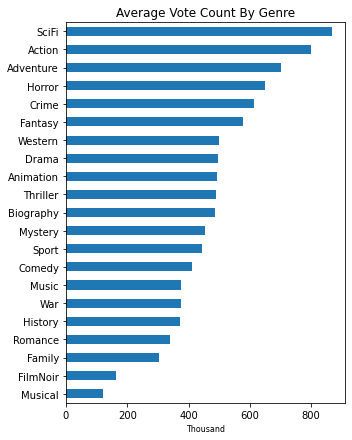

In [47]:
plt.figure(figsize=(5,7))
count_mean_df['Count_All_All_Ages'].plot.barh()
plt.xlabel('Thousand', size=8)
plt.title('Average Vote Count By Genre')
plt.xticks([0,200000,400000,600000,800000], [0, 200, 400, 600, 800])
plt.show()

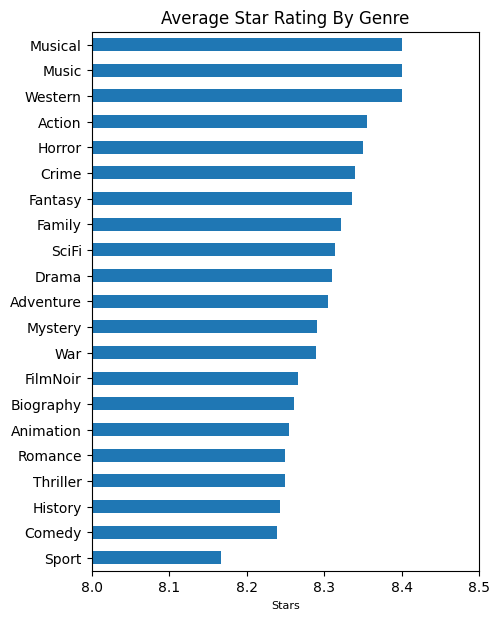

In [101]:
plt.figure(figsize=(5,7))
rank_mean_df['Rank_All_All_Ages'].plot.barh()
plt.xlabel('Stars', size=8)
plt.title('Average Star Rating By Genre')
plt.xlim(8, 8.5)
plt.show()

In [49]:
import seaborn as sns

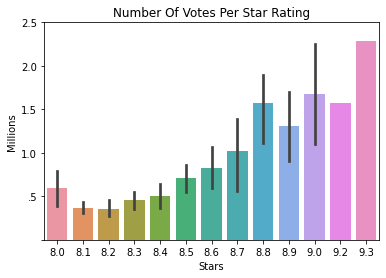

In [50]:
sns.barplot('Rank_All_All_Ages', 'Count_All_All_Ages', data=df)
plt.title('Number Of Votes Per Star Rating')
plt.ylabel('Millions')
plt.xlabel('Stars')

plt.yticks([0,.5e6,1e6,1.5e6,2e6,2.5e6], ['', '.5','1.0','1.5','2.0','2.5'])

plt.show()

In [139]:
mapping = {val:i for val, i in zip(rank_mean_df['Rank_All_All_Ages'].sort_values().index.tolist(), range(len(genres)))}
mapping

{'Action': 17,
 'Adventure': 10,
 'Animation': 5,
 'Biography': 6,
 'Comedy': 1,
 'Crime': 15,
 'Drama': 11,
 'Family': 13,
 'Fantasy': 14,
 'FilmNoir': 7,
 'History': 2,
 'Horror': 16,
 'Music': 19,
 'Musical': 20,
 'Mystery': 9,
 'Romance': 4,
 'SciFi': 12,
 'Sport': 0,
 'Thriller': 3,
 'War': 8,
 'Western': 18}

In [135]:
genres = list(genres)

In [137]:
rank_mean_df['Rank_All_All_Ages']['Action']

8.355813953488376

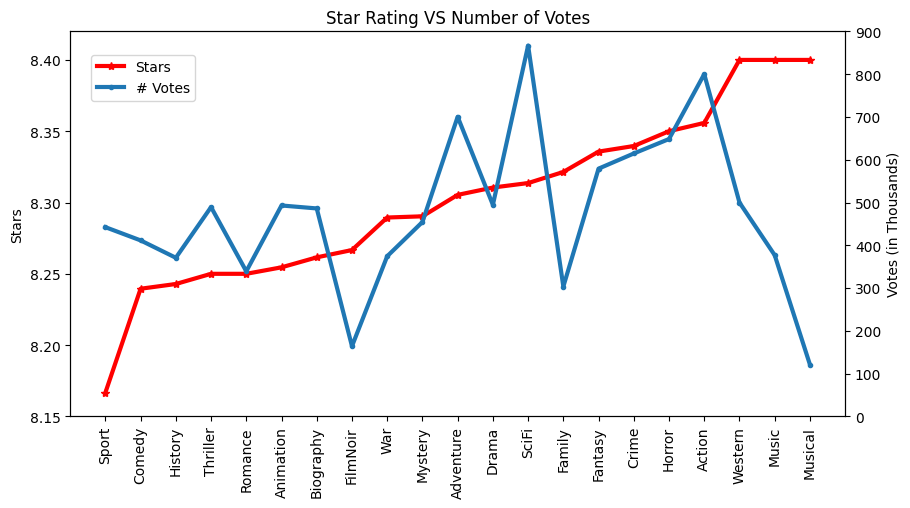

In [224]:
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(range(len(genres)), rank_mean_df['Rank_All_All_Ages'], color='r', marker='*', lw=3)
ax1.set_xticks(range(len(genres)))
ax1.set_xticklabels(rank_mean_df['Rank_All_All_Ages'].index, rotation=90)
ax1.set_ylim(8.15, 8.42)
ax1.set_ylabel('Stars')

ax2 = ax1.twinx()
ax2.plot(range(len(genres)), [count_mean_df['Count_All_All_Ages'][genre] for genre in mapping.keys()], marker='.', lw=3)
ax2.set_ylim(0, 900000)
ax2.set_yticklabels(np.arange(0, 10)*100)
ax2.set_ylabel('Votes (in Thousands)')

ax2.set_title('Star Rating VS Number of Votes')

fig.legend(['Stars', '# Votes'], loc=(.1, .8))

plt.show()

In [103]:
rank_mean_df

,index,Rank_All_All_Ages,Rank_All_<18,Rank_All_18-29,Rank_All_30-44,Rank_All_45+,Rank_Male_All_Ages,Rank_Male_<18,Rank_Male_18-29,Rank_Male_30-44,Rank_Male_45+,Rank_Female_All_Ages,Rank_Female_<18,Rank_Female_18-29,Rank_Female_30-44,Rank_Female_45+
Sport,mean,8.166667,8.233333,8.216667,8.116667,7.950000,8.166667,8.266667,8.250000,8.133333,7.966667,7.966667,7.916667,8.050000,7.933333,7.866667
Comedy,mean,8.239535,8.183721,8.327907,8.202326,8.065116,8.227907,8.223256,8.327907,8.193023,8.048837,8.253488,7.925581,8.293023,8.234884,8.093023
History,mean,8.242857,8.342857,8.350000,8.207143,8.128571,8.235714,8.335714,8.335714,8.200000,8.100000,8.264286,8.192857,8.285714,8.207143,8.285714
Thriller,mean,8.250000,8.234211,8.323684,8.223684,8.092105,8.260526,8.302632,8.344737,8.228947,8.100000,8.144737,7.910526,8.163158,8.107895,8.039474
Romance,mean,8.250000,8.204167,8.341667,8.183333,8.095833,8.212500,8.291667,8.345833,8.187500,8.079167,8.283333,7.933333,8.320833,8.250000,8.158333
Animation,mean,8.254545,8.331818,8.359091,8.204545,7.990909,8.222727,8.350000,8.331818,8.159091,7.945455,8.381818,8.213636,8.422727,8.363636,8.172727
Biography,mean,8.261538,8.346154,8.384615,8.211538,8.046154,8.257692,8.350000,8.380769,8.207692,8.030769,8.257692,8.096154,8.330769,8.188462,8.173077
FilmNoir,mean,8.266667,8.300000,8.266667,8.233333,8.400000,8.266667,8.333333,8.266667,8.233333,8.400000,8.166667,8.033333,8.066667,8.133333,8.366667
War,mean,8.289474,8.300000,8.363158,8.268421,8.221053,8.294737,8.363158,8.373684,8.273684,8.215789,8.189474,7.984211,8.205263,8.157895,8.157895
Mystery,mean,8.290323,8.306452,8.374194,8.248387,8.151613,8.296774,8.393548,8.406452,8.254839,8.145161,8.183871,7.767742,8.219355,8.145161,8.109677


Average Rating Per Year
